**Instalación**


In [ ]:
!pip install imbalanced-learn matplotlib seaborn pandas numpy scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existin

**Importaciones y Configuración**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE

**Configuraciones**

In [2]:
#Configuración visual
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

#Directorio de salida
OUTPUT_DIR = 'outputs_dt'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Semilla para reproducibilidad
RANDOM_STATE = 42

#Varibale objetivo
TARGET_VARIABLE = 'ESTADO_PROGRAMA'

#Ruta del dataset
DATA_FILE = '/content/drive/MyDrive/Estudios/UNIR/04. Máster en IA/07. TFE/DATA/data_arboles_decision/dataset_estudiantes_desercion_arboles_decision.csv'

#configuración del Árbol (Interpretabilidad)

TREE_CONFIG = {
    'max_depth': 4,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'criterion': 'gini',
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE
}

print(f"Configuración Multiclase cargada. Objetivo: {TARGET_VARIABLE}")

Configuración Multiclase cargada. Objetivo: ESTADO_PROGRAMA


**Carga y Preprocesamiento (Uso intensivo de RAM)**

In [3]:
#Definición de columnas a excluir
COLUMNAS_EXCLUIR = [
    'TIPO_DOCUMENTO', 'COHORTE', 'PERIODO_ACADEMICO', 'FRANJA', 'ESTADO_ESTUDIANTE_PERIODO',
    'ID_ESTUDIANTE', 'DOCUMENTO', 'CODPROG_MATRICULA', 'PROGRAMA_COD'
]
#agregar las otras variables objetivo para evitar "data leakage"
otras_targets = ['ESTADO_PROGRAMA', 'ESTADO_IES', 'ESTADO_SISTEMA']
COLUMNAS_EXCLUIR.extend([t for t in otras_targets if t != TARGET_VARIABLE])


df = pd.read_csv(DATA_FILE, sep=';', encoding='latin-1', low_memory=False)

#Selección de columnas
cols_disponibles = [c for c in df.columns if c not in COLUMNAS_EXCLUIR]
df_clean = df[cols_disponibles].copy()

#Limpieza de variable objetivo
valores_nulos = ['SIN INFORMACIÓN', 'SIN_INFO', 'nan', 'NaN', 'No aplica', 'NO APLICA']
df_clean.replace(valores_nulos, np.nan, inplace=True)

#eliminar filas donde el objetivo sea nulo
df_clean = df_clean[df_clean[TARGET_VARIABLE].notna()]

#aplicación de LabelEncoder (multiclase automático)
le = LabelEncoder()
df_clean['TARGET'] = le.fit_transform(df_clean[TARGET_VARIABLE])

#nombres para el gráfico del árbol
class_names_str = [str(c) for c in le.classes_]
print(f"Clases detectadas: {class_names_str}")
print(f"Mapeo interno: {dict(zip(le.classes_, le.transform(le.classes_)))}")

if TARGET_VARIABLE in df_clean.columns:
    df_clean.drop(columns=[TARGET_VARIABLE], inplace=True)

#Imputación de valores
y = df_clean['TARGET']
X_temp = df_clean.drop(columns=['TARGET'])

#Imputación numérica
num_cols = X_temp.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if X_temp[col].isnull().any():
        X_temp[col] = X_temp[col].fillna(X_temp[col].median())

#Imputación categórica
cat_cols = X_temp.select_dtypes(include=['object']).columns
for col in cat_cols:
    if X_temp[col].isnull().any():
        moda = X_temp[col].mode()
        val = moda[0] if len(moda) > 0 else 'DESCONOCIDO'
        X_temp[col] = X_temp[col].fillna(val)

#Encoding
cols_codificar = [c for c in cat_cols if X_temp[c].nunique() <= 20] # Umbral 20 para árboles
X = pd.get_dummies(X_temp, columns=cols_codificar, drop_first=True, dtype=int)
X = X.select_dtypes(exclude=['object']) # Limpiar remanentes

#Paso para asegurar la alineación
y = y.loc[X.index]

#Escalado
X = X.astype('float32')
scaler = StandardScaler()
X[:] = scaler.fit_transform(X)
feature_names = X.columns.tolist()

print(f"Matriz lista: {X.shape}")

Clases detectadas: ['Ausente', 'Desertor', 'Graduado']
Mapeo interno: {'Ausente': np.int64(0), 'Desertor': np.int64(1), 'Graduado': np.int64(2)}
Matriz lista: (824786, 252)


**División y SMOTE (Balanceo)**

In [4]:
#proceso de fraccionamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Train original: {X_train.shape[0]:,} muestras")

#aplicación de SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=4)

try:
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print(f"Balanceo completado exitosamente.")
    print(f"Train Balanceado: {X_train_bal.shape[0]:,} muestras")

    conteo = y_train_bal.value_counts().sort_index()
    #uso de labelencoder por ser muilticlase
    nombres = le.inverse_transform(conteo.index)
    distribucion_legible = dict(zip(nombres, conteo.values))

    print(f"Distribución final por clase: {distribucion_legible}")

except ValueError as e:
    print(f"Falló SMOTE ({e}).")
    print("Probablemente una clase tiene muy pocos datos (< 5).")
    print("Se usará el dataset sin balancear.")
    X_train_bal, y_train_bal = X_train, y_train
except Exception as e:
    print(f"Error inesperado en SMOTE: {e}. Usando datos originales.")
    X_train_bal, y_train_bal = X_train, y_train

Train original: 659,828 muestras
Balanceo completado exitosamente.
Train Balanceado: 802,044 muestras
Distribución final por clase: {'Ausente': np.int64(267348), 'Desertor': np.int64(267348), 'Graduado': np.int64(267348)}


**Entrenamiento y Validación Cruzada**

In [5]:
#Instanciar el modelo
dt_model = DecisionTreeClassifier(**TREE_CONFIG)

#aplñicación de la validación cruzada
print("Ejecutando validación cruzada (10-fold)")
cv_scores = cross_val_score(dt_model, X_train_bal, y_train_bal, cv=10, scoring='f1_macro', n_jobs=-1)

print(f"F1-Score Macro promedio en validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

#Entrenamiento final
dt_model.fit(X_train_bal, y_train_bal)

print("Modelo entrenado exitosamente.")
print(f"Profundidad final: {dt_model.get_depth()} | Hojas: {dt_model.get_n_leaves()}")

Ejecutando validación cruzada (10-fold)
F1-Score Macro promedio en validación cruzada: 0.7803 (+/- 0.0025)
Modelo entrenado exitosamente.
Profundidad final: 4 | Hojas: 13


**Evaluación y Gráficos (Resultados)**


RESULTADOS MULTICLASE PARA: ESTADO_PROGRAMA
--------------------------------------------------
Accuracy Global:   0.7782
Macro Recall:      0.7738  (Promedio de detección por clase)
Macro F1-Score:    0.7629   (Equilibrio general)
Macro AUC-ROC:     0.9044
--------------------------------------------------

--- Reporte Detallado ---
              precision    recall  f1-score   support

     Ausente       0.81      0.72      0.76     61928
    Desertor       0.51      0.76      0.61     36192
    Graduado       1.00      0.84      0.91     66838

    accuracy                           0.78    164958
   macro avg       0.77      0.77      0.76    164958
weighted avg       0.82      0.78      0.79    164958



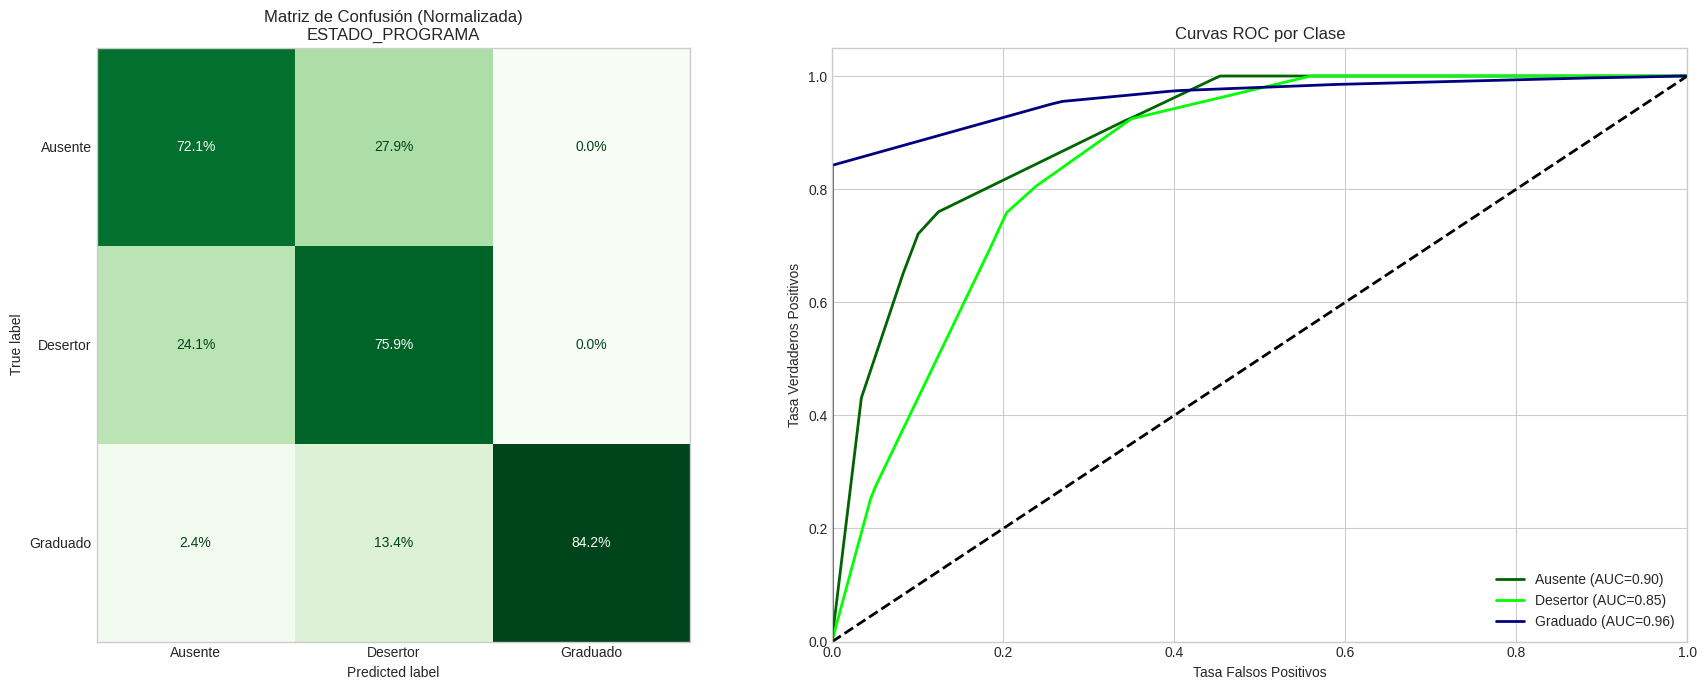

In [6]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

#Predicciones, para Multiclase, y_prob debe ser la matriz completa, no solo la columna [:, 1]
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)

#Métricas, usamos average='macro' para tratar todas las clases con igual importancia
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

#AUC multiclase (One-vs-Rest)
try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
except ValueError:
    print("No se pudo calcular AUC (posiblemente falta una clase en el test set).")
    auc = 0.5

print()
print(f"RESULTADOS MULTICLASE PARA: {TARGET_VARIABLE}")
print("-" * 50)
print(f"Accuracy Global:   {acc:.4f}")
print(f"Macro Recall:      {rec:.4f}  (Promedio de detección por clase)")
print(f"Macro F1-Score:    {f1:.4f}   (Equilibrio general)")
print(f"Macro AUC-ROC:     {auc:.4f}")
print("-" * 50)

#Reporte de texto, convertimos las clases a strings para que el reporte sea legible
nombres_clases = [str(c) for c in le.classes_]
print()
print("--- Reporte Detallado ---")
print(classification_report(y_test, y_pred, target_names=nombres_clases))


#Gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=nombres_clases,
    cmap='Greens',
    normalize='true',
    values_format=".1%",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title(f'Matriz de Confusión (Normalizada)\n{TARGET_VARIABLE}')
axes[0].grid(False)

#Curvas ROC (One-vs-Rest)
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
colors = cycle(['darkgreen', 'lime', 'navy', 'darkorange', 'teal'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])

    axes[1].plot(
        fpr, tpr,
        color=color,
        lw=2,
        label=f'{nombres_clases[i]} (AUC={roc_auc:.2f})'
    )

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa Falsos Positivos')
axes[1].set_ylabel('Tasa Verdaderos Positivos')
axes[1].set_title('Curvas ROC por Clase')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

**Interpretabilidad (Reglas de Texto e Importancia)**

--- FASE E: INTERPRETABILIDAD (REGLAS E IMPORTANCIA) ---


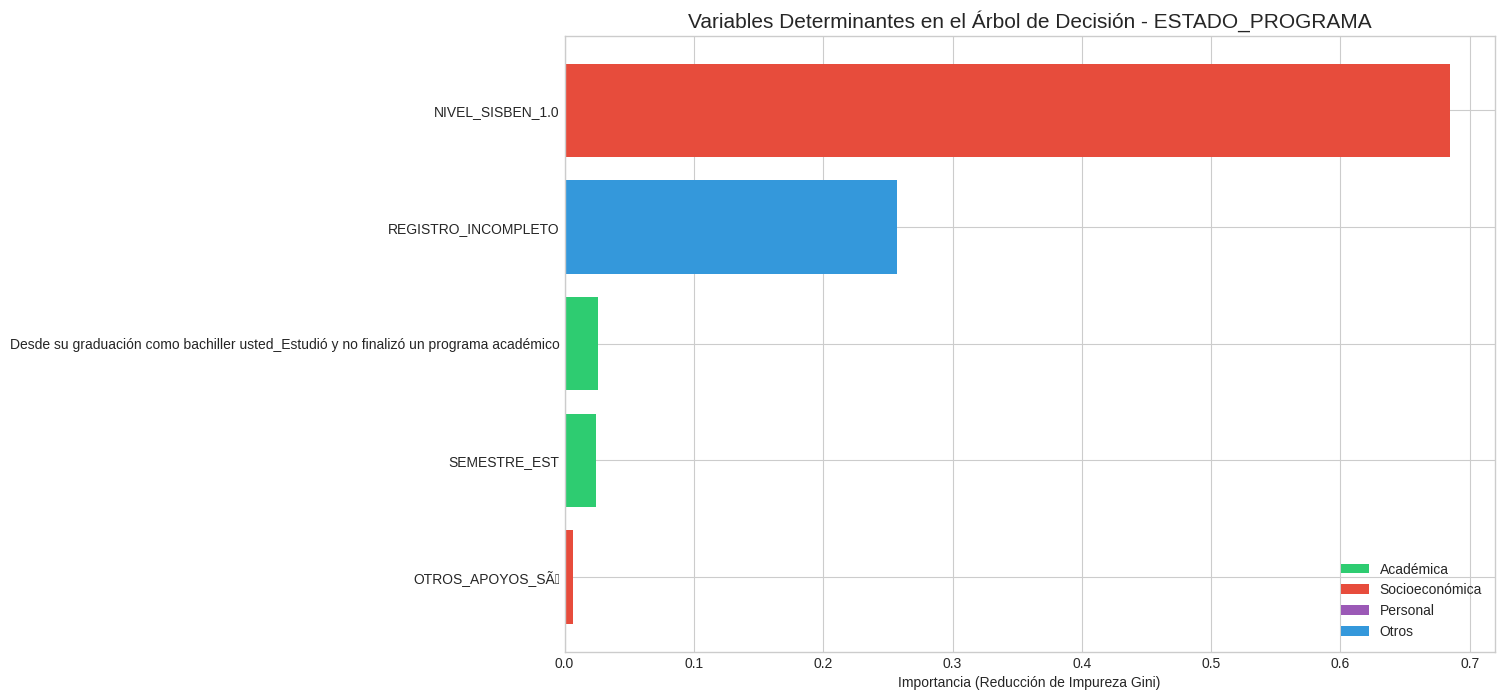


--- REGLAS DE DECISIÓN (LÓGICA INTERNA) ---
Guía de lectura para las clases:
  Class 0  ->  Ausente
  Class 1  ->  Desertor
  Class 2  ->  Graduado

Reglas extraídas (Profundidad 3):
------------------------------
|--- NIVEL_SISBEN_1.0 <= -0.47
|   |--- REGISTRO_INCOMPLETO <= -0.43
|   |   |--- ¿Cuál de las siguientes opciones definen mejor la razón principal por la cual usted eligió el actual programa de estudios?_No conoce otras opciones <= 5.48
|   |   |   |--- Desde su graduación como bachiller usted_Estudió y no finalizó un programa académico <= 0.82
|   |   |   |   |--- class: 1
|   |   |   |--- Desde su graduación como bachiller usted_Estudió y no finalizó un programa académico >  0.82
|   |   |   |   |--- class: 1
|   |   |--- ¿Cuál de las siguientes opciones definen mejor la razón principal por la cual usted eligió el actual programa de estudios?_No conoce otras opciones >  5.48
|   |   |   |--- class: 0
|   |--- REGISTRO_INCOMPLETO >  -0.43
|   |   |--- NUM_HERMANOS_2.0 <= -

In [9]:
print("--- FASE E: INTERPRETABILIDAD (REGLAS E IMPORTANCIA) ---")

# 1. Feature Importance (Estilo Tesis)
importances = dt_model.feature_importances_

# Aseguramos que feature_names existe
if 'feature_names' not in locals():
    feature_names = X_train.columns.tolist()

df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Filtramos las que tienen importancia 0 para limpiar el gráfico
df_imp = df_imp[df_imp['Importance'] > 0.001].sort_values('Importance', ascending=False).head(15)

# Función de colores (Misma que en RF para consistencia)
def get_category_color(name):
    name = name.lower()
    if any(x in name for x in ['nota', 'promedio', 'semestre', 'creditos', 'programa', 'materia']):
        return '#2ecc71' # Verde (Académico)
    elif any(x in name for x in ['estrato', 'ingreso', 'sisben', 'trabaj', 'apoyo', 'financ']):
        return '#e74c3c' # Rojo (Socioeconómico)
    elif any(x in name for x in ['edad', 'sexo', 'civil', 'hijos', 'genero']):
        return '#9b59b6' # Morado (Personal)
    else:
        return '#3498db' # Azul (Otro)

colors = df_imp['Feature'].apply(get_category_color)

# Gráfico de Barras
plt.figure(figsize=(12, 8))
bars = plt.barh(df_imp['Feature'], df_imp['Importance'], color=colors)
plt.gca().invert_yaxis() # La más importante arriba
plt.title(f"Variables Determinantes en el Árbol de Decisión - {TARGET_VARIABLE}", fontsize=15)
plt.xlabel("Importancia (Reducción de Impureza Gini)")

# Leyenda manual
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Académica'),
    Patch(facecolor='#e74c3c', label='Socioeconómica'),
    Patch(facecolor='#9b59b6', label='Personal'),
    Patch(facecolor='#3498db', label='Otros')
]
plt.legend(handles=legend_elements, loc='lower right')
plt.show()


# 2. Reglas de Texto (Con traducción de clases)
print("\n--- REGLAS DE DECISIÓN (LÓGICA INTERNA) ---")
print("Guía de lectura para las clases:")
# Imprimimos el mapa para que puedas leer la salida de texto
mapa_clases = dict(zip(range(len(le.classes_)), le.classes_))
for num, nombre in mapa_clases.items():
    print(f"  Class {num}  ->  {nombre}")

print("\nReglas extraídas (Profundidad 3):")
print("-" * 30)
# export_text muestra la lógica pura: "Si feature X <= 0.5..."
rules = export_text(dt_model, feature_names=feature_names, max_depth=3)
print(rules)